In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import pystan, GPy, scipy, stan_utility
import pandas as pd

`stan_utility` from case-study [Robust PyStan Workflow](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html) ([source](https://github.com/betanalpha/jupyter_case_studies/tree/master/pystan_workflow))



In [394]:
def plotFunctionSamples(param, x=None, plotKwargs={}, fillKwargs={}, **kwargs):
    if x is None:
        x = np.arange(param.shape[1])
        
    plotKwargs.update(kwargs)
    fillKwargs.update(kwargs)
    
    plt.plot(x, param.mean(0), **plotKwargs)
    plt.fill_between(x, param.mean(0)-1.98*param.std(0), param.mean(0)+1.98*param.std(0), alpha=.1, **fillKwargs)

# Example: one-way hierarchical model 

## centered model 

In [380]:
model = pystan.StanModel(file='stan-models/hierarchical-centered.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_079bf6e4e084be7363aab003d644d1d9 NOW.


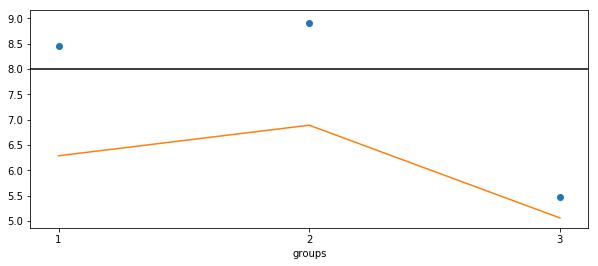

In [435]:
mu = 8.
tau = 3.
ysigma=3
n = 10
g = 3
nrep = 1

theta = scipy.stats.norm.rvs(mu, scale=tau, size=g)
y = scipy.stats.norm.rvs(np.repeat(theta, nrep), scale=ysigma)

plt.figure(figsize=(10,4))

plt.axhline(mu, c='k')

plt.plot(range(1, g+1), theta, 'C1')
plt.scatter(np.repeat(np.arange(1, g+1), nrep), y)
plt.xticks(np.arange(1, g+1))
plt.xlabel('groups')

# plt.savefig('figures/hierarchical-data.pdf', bbox_inches='tight')

In [354]:
config = {
    'N': g*nrep,
    'G': g,
    'group': np.repeat(1+np.arange(g), nrep),
    'y': y,
    'sigma': ysigma
}

samples = model.sampling(data=config, chains=4, iter=2000)
samples

Inference for Stan model: anon_model_079bf6e4e084be7363aab003d644d1d9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         6.45    0.08   2.41   0.72   5.25   6.62   7.99  10.59  946.0    1.0
tau        2.72    0.12   2.94   0.41   1.04    1.9   3.41   9.67  572.0    1.0
theta[0]   6.96    0.06   2.16    2.6   5.61   6.94   8.35  11.42 1377.0    1.0
theta[1]   6.27    0.06   2.24   1.42   4.91   6.42   7.75  10.39 1333.0    1.0
theta[2]   8.58    0.08   2.53   4.33   6.84    8.3  10.05  14.37  971.0   1.01
yhat[0]    6.96    0.06   2.16    2.6   5.61   6.94   8.35  11.42 1377.0    1.0
yhat[1]    6.27    0.06   2.24   1.42   4.91   6.42   7.75  10.39 1333.0    1.0
yhat[2]    8.58    0.08   2.53   4.33   6.84    8.3  10.05  14.37  971.0   1.01
lp__      -5.87    0.12   2.43 -11.27  -7.31  -5.62   -4.1  -1.92  389.0    1.0

Samples we

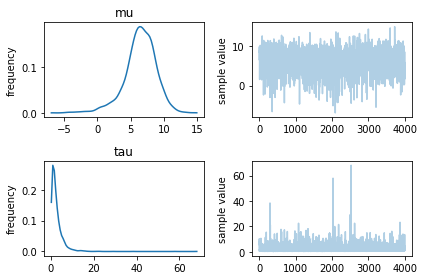

In [355]:
samples.plot(['mu', 'tau']);
plt.tight_layout()

In [356]:
stan_utility.check_treedepth(samples)

0 of 4000 iterations saturated the maximum tree depth of 10 (0%)


In [357]:
stan_utility.check_div(samples)

120.0 of 4000 iterations ended with a divergence (3.0%)
Try running with larger adapt_delta to remove the divergences


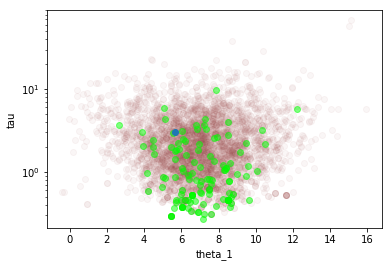

In [358]:
nondiv_params, div_params = stan_utility.partition_div(samples)

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

plt.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.05)
plt.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plt.semilogy()
plt.scatter(theta[0], tau)

plt.xlabel('theta_1')
plt.ylabel('tau')

In [359]:
samp = samples.extract()
samp

OrderedDict([(u'mu',
              array([ 9.76677286,  8.69090068,  8.43408048, ...,  1.64940648,
                      5.71176571,  5.81633564])),
             (u'tau',
              array([  5.73326407,  10.24173947,   1.54662775, ...,  13.55042307,
                       0.88182239,   3.10863879])),
             (u'theta', array([[  7.17447318,   8.3490627 ,  15.36386884],
                     [  4.0300929 ,   7.24056941,   8.04798943],
                     [  8.09232638,   9.40596801,  10.18677518],
                     ..., 
                     [  8.94101622,   4.13885385,   8.35412121],
                     [  6.12756572,   7.01689533,   6.80399931],
                     [  6.80467746,   6.78714906,  10.04690573]])),
             (u'yhat', array([[  7.17447318,   8.3490627 ,  15.36386884],
                     [  4.0300929 ,   7.24056941,   8.04798943],
                     [  8.09232638,   9.40596801,  10.18677518],
                     ..., 
                     [  8.94101622

In [360]:
samp['mu'].shape

(4000,)

In [361]:
samp['tau'].shape

(4000,)

In [362]:
samp['theta'].shape

(4000, 3)

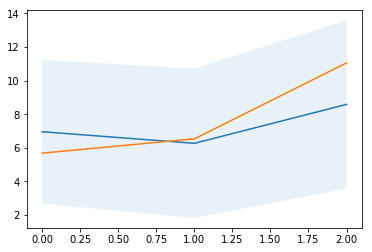

In [363]:
plt.plot(samp['theta'].mean(0))
plt.fill_between(range(g), 
                 samp['theta'].mean(0) - 1.98*samp['theta'].std(0), 
                 samp['theta'].mean(0) + 1.98*samp['theta'].std(0),
                alpha=.1)

plt.plot(theta)

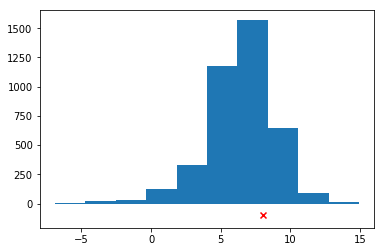

In [364]:
plt.hist(samp['mu'])
plt.scatter([mu], [-100], marker='x', color='r')

## non-centered model 

In [365]:
model_nc = pystan.StanModel(file='stan-models/hierarchical-noncentered.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97f8fd15f1f040c35337dc5141217c00 NOW.


In [373]:
config = {
    'N': g*nrep,
    'G': g,
    'group': np.repeat(1+np.arange(g), nrep),
    'y': y,
    'sigma': ysigma
}

samples = model_nc.sampling(data=config, chains=4, iter=2000)
samp = samples.extract()

In [374]:
samples

Inference for Stan model: anon_model_97f8fd15f1f040c35337dc5141217c00.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               6.58    0.07   2.27   1.37   5.32   6.74   8.06  10.65 1003.0    1.0
tau              2.42    0.09   2.45   0.07   0.76   1.69   3.25   9.21  798.0    1.0
theta_tilde[0]    0.1    0.02   0.88  -1.67  -0.48   0.15   0.69   1.84 2747.0    1.0
theta_tilde[1]  -0.14    0.02   0.87  -1.88  -0.69  -0.13   0.44   1.58 2299.0    1.0
theta_tilde[2]    0.6    0.02   0.92   -1.4   0.03   0.62   1.23   2.32 2040.0    1.0
yhat[0]          7.08    0.03   2.17   2.61   5.66   7.07   8.47  11.42 4000.0    1.0
yhat[1]           6.4    0.04   2.31    1.6   4.95   6.49   7.97  10.53 3012.0    1.0
yhat[2]          8.45    0.04   2.42   4.23   6.81   8.24   9.92  13.85 4000.0    1.0
theta[0]         7.08    0.03   2.17 

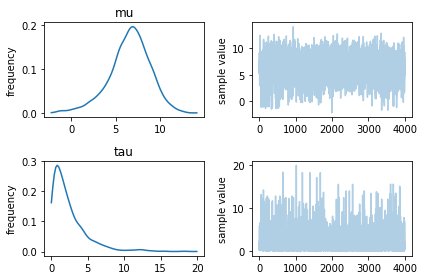

In [375]:
samples.plot(['mu', 'tau']);
plt.tight_layout()

In [376]:
stan_utility.check_treedepth(samples)

0 of 4000 iterations saturated the maximum tree depth of 10 (0%)


In [377]:
stan_utility.check_div(samples)

9.0 of 4000 iterations ended with a divergence (0.225%)
Try running with larger adapt_delta to remove the divergences


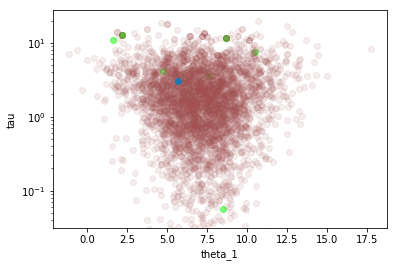

In [378]:
nondiv_params, div_params = stan_utility.partition_div(samples)

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

plt.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plt.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.1)


plt.semilogy()

plt.scatter(theta[0], tau)

plt.xlabel('theta_1')
plt.ylabel('tau')


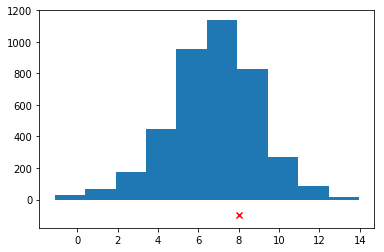

In [372]:
plt.hist(samp['mu'])
plt.scatter([mu], [-100], marker='x', color='r')

# GP model 

In [162]:
gp_model = pystan.StanModel(file='stan-models/gp-base.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ab43e9fe84bbbfd6f147230c3a83efb7 NOW.


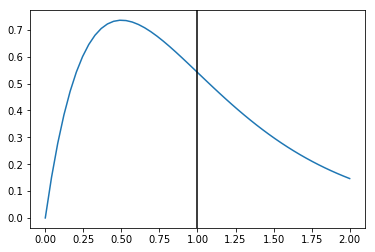

In [413]:
alpha, beta = 2,2

z = np.linspace(0, 2)
plt.plot(z, scipy.stats.gamma.pdf(z, alpha, scale=1./beta))
plt.axvline(alpha/beta,color='k')

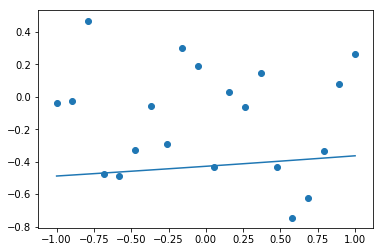

In [429]:
n = 20
x = np.linspace(-1,1,n)
k = GPy.kern.RBF(1, lengthscale=10)

cov = np.tile(k.K(x[:,None]), (2,2))
cov[:n, :n] += .1 * np.eye(n)

s = scipy.stats.multivariate_normal.rvs(np.zeros(2*n), cov)
y, f = s[:n], s[n:]

plt.plot(x, f)
plt.scatter(x, y)

In [430]:
cfg = {
    'N': n,
    'y': y,
    'x': x
}

samples = gp_model.sampling(data=cfg, iter=2000)
samp = samples.extract()
samples

Inference for Stan model: anon_model_ab43e9fe84bbbfd6f147230c3a83efb7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
length_scale   0.95    0.04   0.79   0.09   0.32   0.77   1.36   2.92  347.0   1.01
alpha          0.26  6.5e-3   0.23   0.01   0.11   0.21   0.34   0.88 1192.0    1.0
sigma          0.34  4.9e-3   0.08   0.18   0.29   0.34   0.39    0.5  242.0   1.02
f_eta[0]       -0.2    0.02    0.7  -1.68  -0.62  -0.19    0.2   1.24 2084.0    1.0
f_eta[1]      -0.23    0.02   0.88  -1.97  -0.82  -0.23   0.35   1.52 1423.0    1.0
f_eta[2]      -0.26    0.02   0.93  -2.12  -0.87  -0.26   0.37   1.52 1757.0    1.0
f_eta[3]      -0.29    0.04    1.0  -2.14  -0.99   -0.3    0.4    1.7  771.0   1.01
f_eta[4]      -0.14    0.02   0.99  -2.05  -0.82  -0.13   0.52   1.77 2172.0    1.0
f_eta[5]      -0.06    0.02   0.96  -1.95  -0.72  -0.07

In [431]:
samp.keys()

[u'length_scale', u'alpha', u'sigma', u'f_eta', u'f', u'lp__']

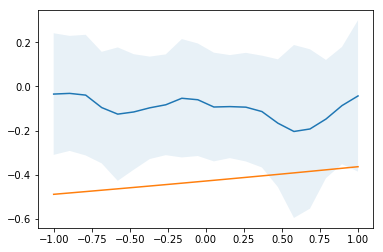

In [432]:
plotFunctionSamples(samp['f'], x)
plt.plot(x, f, c='C1')

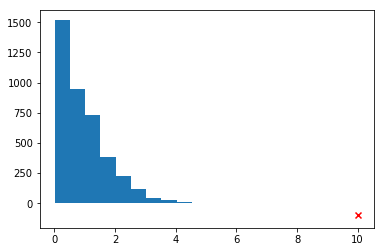

In [433]:
plt.hist(samp['length_scale'])
plt.scatter([k.lengthscale], [-100], marker='x', color='r')

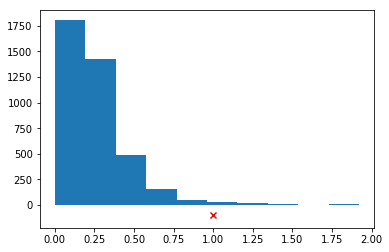

In [434]:
plt.hist(samp['alpha'])
plt.scatter([k.variance], [-100], marker='x', color='r')

## functional linear model 

Now we want to calculate a model such that:

$y_r(x) = \sum_{i=1}^k M_{r,i} \cdot \beta_{i}(x) + \epsilon(x) $

In [242]:
flm_model = pystan.StanModel(file='stan-models/gp-flm.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c47276819230458b856debe208701b5a NOW.


In [438]:
n = 20
rep = 3
x = np.linspace(-1,1,n)
ysigma = .1

k1 = GPy.kern.RBF(1)
k2 = GPy.kern.RBF(1, variance=.1)

f1 = scipy.stats.multivariate_normal.rvs(np.zeros(n), k1.K(x[:,None]))
f2 = scipy.stats.multivariate_normal.rvs(np.zeros(n), k2.K(x[:,None]))

y1 = (f1 + f2)[:,None] + scipy.stats.norm.rvs(size=(n,rep), scale=ysigma)
y2 = (f1 - f2)[:,None] + scipy.stats.norm.rvs(size=(n,rep), scale=ysigma)

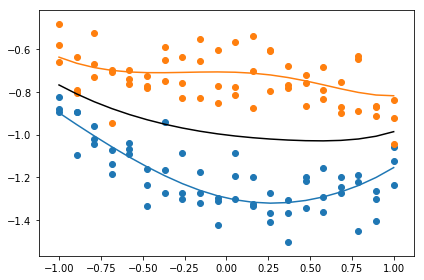

In [439]:
plt.plot(x, f1, c='k')
plt.plot(x, f1+f2, 'C0')
plt.plot(x, f1-f2, 'C1')

plt.scatter(np.repeat(x[:,None], rep, axis=1), y1, color='C0')
plt.scatter(np.repeat(x[:,None], rep, axis=1), y2, color='C1')

plt.tight_layout()

In [440]:
y = np.column_stack((y1,y2))

dm = np.ones((y.shape[1], 2))
dm[rep:,1] = -1
dm

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1., -1.],
       [ 1., -1.],
       [ 1., -1.]])

In [441]:
np.linalg.matrix_rank(dm)

2

In [442]:
config = dict(
    N = n,
    P = y.shape[1],
    K = 2,
    L = 2,
    
    prior = [1, 2],
    alpha_prior = [[1,1], [.1, 1]],
    lengthscale_prior = [[0,1]]*2,
    sigma_prior = [1,1],
    
    y = y.T,
    design = dm,
    x = x
)

In [443]:
samples = flm_model.sampling(data = config)
samp = samples.extract()
samples

Inference for Stan model: anon_model_c47276819230458b856debe208701b5a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lengthscale[0]   2.85    0.03   1.35   1.11    1.9   2.63    3.5   6.03 1559.0    1.0
lengthscale[1]   1.18    0.01   0.41   0.59    0.9   1.11   1.38   2.19 1600.0    1.0
alpha[0]         0.95    0.01   0.44    0.4   0.63   0.84   1.17    2.1 1424.0    1.0
alpha[1]         0.26  4.6e-3   0.18    0.1   0.15   0.21    0.3   0.73 1505.0    1.0
sigma             0.1  1.1e-4 6.7e-3   0.09    0.1    0.1    0.1   0.11 4000.0    1.0
f_eta[0,0]      -1.01    0.01   0.43  -1.99  -1.26  -0.94  -0.68  -0.38 1362.0    1.0
f_eta[1,0]      -0.62  7.8e-3   0.32  -1.34  -0.81  -0.57  -0.39  -0.15 1653.0    1.0
f_eta[0,1]      -0.97 10.0e-3   0.39  -1.87   -1.2  -0.91  -0.69  -0.38 1501.0    1.0
f_eta[1,1]      -1.03    0.01   0.61 

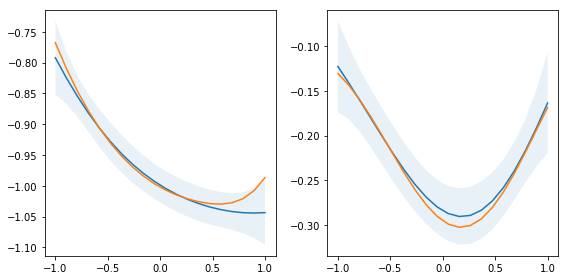

In [453]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plotFunctionSamples(samp['f'][:,0], x)
plt.plot(x,f1)

plt.subplot(122)
plotFunctionSamples(samp['f'][:,1], x)
plt.plot(x,f2)

plt.tight_layout()

### hierarchical model 

In [457]:
n = 20
rep = 3
x = np.linspace(-1,1,n)
ysigma = .1

k1 = GPy.kern.RBF(1)
k2 = GPy.kern.RBF(1, variance=.3)

f1 = scipy.stats.multivariate_normal.rvs(np.zeros(n), k1.K(x[:,None]))
f21 = scipy.stats.multivariate_normal.rvs(np.zeros(n), k2.K(x[:,None]))
f22 = scipy.stats.multivariate_normal.rvs(np.zeros(n), k2.K(x[:,None]))

y1 = (f1 + f21)[:,None] + scipy.stats.norm.rvs(size=(n,rep), scale=ysigma)
y2 = (f1 + f22)[:,None] + scipy.stats.norm.rvs(size=(n,rep), scale=ysigma)

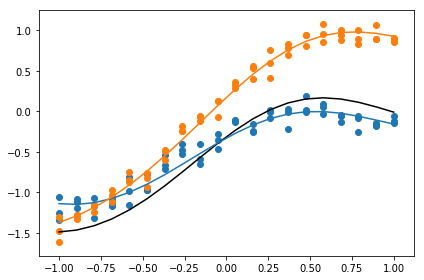

In [458]:
plt.plot(x, f1, c='k')
plt.plot(x, f1+f21, 'C0')
plt.plot(x, f1+f22, 'C1')

plt.scatter(np.repeat(x[:,None], rep, axis=1), y1, color='C0')
plt.scatter(np.repeat(x[:,None], rep, axis=1), y2, color='C1')

plt.tight_layout()

In [459]:
y = np.column_stack((y1,y2))

dm = np.zeros((y.shape[1], 3))
dm[:,0] = 1
dm[:rep,1] = 1 
dm[rep:,2] = 1 
dm

array([[ 1.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  1.]])

In [460]:
np.linalg.matrix_rank(dm)

2

In [461]:
config = dict(
    N = n,
    P = y.shape[1],
    K = 3,
    L = 2,
    
    prior = [1, 2, 2],
    alpha_prior = [[1,1], [.1, 1]],
    lengthscale_prior = [[0,1]]*2,
    sigma_prior = [1,1],
    
    y = y.T,
    design = dm,
    x = x
)

In [462]:
samples = flm_model.sampling(data = config)
samp = samples.extract()
samples

Inference for Stan model: anon_model_c47276819230458b856debe208701b5a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lengthscale[0]   1.17    0.04   0.97   0.54   0.84   0.99   1.17   3.31  679.0   1.01
lengthscale[1]    1.5    0.03   0.79   0.67   0.98   1.27   1.79   3.66  927.0    1.0
alpha[0]         0.86    0.02   0.47    0.1   0.55   0.79   1.09   2.04  826.0    1.0
alpha[1]         0.65  9.4e-3   0.33   0.26   0.43   0.57    0.8    1.5 1222.0    1.0
sigma             0.1  1.1e-4 6.6e-3   0.09   0.09    0.1    0.1   0.11 4000.0    1.0
f_eta[0,0]      -1.21    0.03   0.74  -2.66  -1.67   -1.2  -0.79   0.41  581.0    1.0
f_eta[1,0]      -0.35    0.03   0.71  -1.76  -0.82  -0.35   0.13   1.06  756.0    1.0
f_eta[2,0]       -0.7    0.02   0.69  -2.07  -1.15  -0.68  -0.24   0.66  928.0    1.0
f_eta[0,1]       0.44    0.01   0.55 

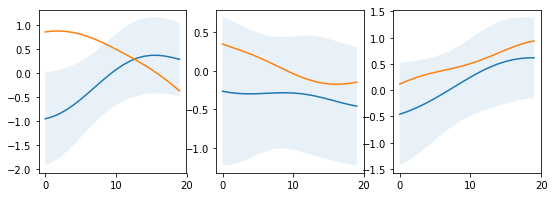

In [466]:
plt.figure(figsize=(9,3))

for i,f in enumerate([f1, f21, f22]):
    plt.subplot(1,dm.shape[1],i+1)
    plotFunctionSamples(samp['f'][:,i])
    plt.plot(f)

# Delorean Model 

In [52]:
delorean = pystan.StanModel(file='stan-models/delorean/exact.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d076b8f826bca8c4fe13aba5c721868 NOW.


In [75]:
ds = 'windram'

meta = pd.read_csv('data/delorean/%s.cell.meta.csv'%ds, index_col=0)
expr = pd.read_csv('data/delorean/%s.expr.csv'%ds, index_col=0)
genemeta = pd.read_csv('data/delorean/%s.gene.meta.csv'%ds, index_col=0)

In [76]:
meta.shape, expr.shape, genemeta.shape

((48, 4), (150, 48), (150, 2))

In [115]:
meta.head()

,cell,obstime,condition,capture
1,GSM734540,2,Botrytis,2
2,GSM734541,4,Botrytis,4
3,GSM734542,6,Botrytis,6
4,GSM734543,8,Botrytis,8
5,GSM734544,10,Botrytis,10


(array([ 6.,  4.,  4.,  6.,  4.,  4.,  6.,  4.,  4.,  6.]),
 array([  2. ,   6.6,  11.2,  15.8,  20.4,  25. ,  29.6,  34.2,  38.8,
         43.4,  48. ]),
 <a list of 10 Patch objects>)

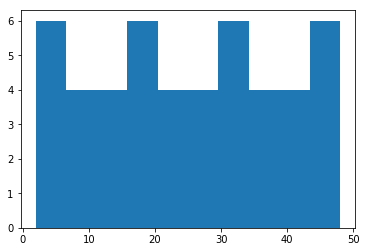

In [78]:
plt.hist(meta.obstime)

In [79]:
expr.head()

,GSM734540,GSM734541,GSM734542,GSM734543,GSM734544,GSM734545,GSM734546,GSM734547,GSM734548,GSM734549,...,GSM734578,GSM734579,GSM734580,GSM734581,GSM734582,GSM734583,GSM734584,GSM734585,GSM734586,GSM734587
CATMA1a00350,9.710897,9.832590,9.884595,9.945775,9.877853,10.202463,9.840159,10.088847,9.810455,9.180298,...,10.117931,10.066953,10.021325,10.377542,9.791147,10.411251,10.198705,10.018750,10.034907,9.884397
CATMA1a00725,12.088297,12.452569,12.808097,12.905720,12.749294,12.902973,12.976291,12.694036,13.259558,12.801453,...,12.436501,12.670511,12.383517,12.084563,12.544240,12.711120,12.803843,12.613040,12.277474,12.115316
CATMA1a00790,6.852164,6.556423,5.563841,5.361028,5.634317,7.145824,5.293819,6.482773,6.372674,5.784951,...,5.716546,6.410615,6.574702,6.308654,6.397054,6.673808,4.963005,5.639637,5.738830,5.041594
CATMA1a02710,9.362607,9.646485,8.855508,8.812352,8.742348,9.077515,9.166195,9.859782,9.956077,9.171175,...,9.053681,8.886858,9.312501,9.417784,10.187124,9.768930,9.970470,9.063829,9.036554,9.740412
CATMA1a05095,7.895253,8.104990,7.441710,7.813741,7.869875,7.599806,7.838487,7.913710,7.438730,7.879663,...,7.999981,7.979035,8.282805,8.069738,8.147884,7.997745,8.299933,8.232949,8.108524,8.110180


In [80]:
genemeta.head()

,gene,TAIR9
1,CATMA1a00350,AT1G01360
2,CATMA1a00725,AT1G01720
3,CATMA1a00790,AT1G01780
4,CATMA1a02710,AT1G03850
5,CATMA1a05095,AT1G06080


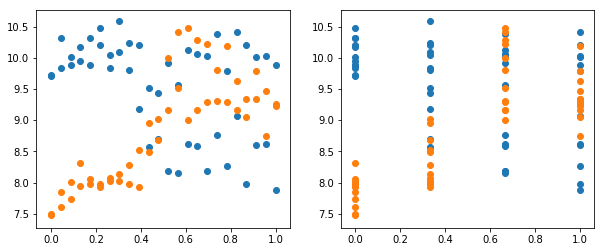

In [125]:
tind = range(0,expr.shape[1],1)

gind = range(2)
gind = [0, 6]

time = meta.obstime.values[tind]
exp = expr.values[gind,:][:, tind]

time = 1.*(time-time.min())/(time.max()-time.min())

timeTrain = np.tile(np.repeat(range(4), 6), 2)
timeTrain = 1.*(timeTrain-timeTrain.min())/(timeTrain.max()-timeTrain.min())

plt.figure(figsize=(10, 4))
plt.subplot(121)
for i in range(exp.shape[0]):
    plt.scatter(time, exp[i,:])
    
plt.subplot(122)
for i in range(exp.shape[0]):
    plt.scatter(timeTrain, exp[i,:])

In [155]:
config = dict(
    C = time.shape[0], #meta.shape[0], # number of cells
    G = 2, # number of genes
    H = 0, # number of held-out genes
    
    periodic = 0, # non-periodic fxn
    period = 0,
    
#     time = meta.obstime.values[:10], # observation time
#     expr = expr.values[:2,:10], # expression data
#     phi = expr.mean(1).values[:2,], # gene mean
    
    time = timeTrain,
    expr= exp,
    phi = exp.mean(1),
    
    # hyperparameters
    mu_psi = 1.,
    sigma_psi = 1.,
    mu_omega = 1.,
    sigma_omega = 1.,
    sigma_tau=0.5,
    l=1.5,
    
    heldout_psi=[],
    heldout_omega=[],
    
    numtest=30,
    testinput = np.linspace(-.5, 1.5, 30),
)

In [156]:
samples = delorean.sampling(data=config)
samp = samples.extract()
samples

Inference for Stan model: anon_model_2d076b8f826bca8c4fe13aba5c721868.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau[0]                -0.3  6.6e-3   0.31  -0.95   -0.5  -0.28  -0.07   0.24 2263.0    1.0
tau[1]               -0.27  5.1e-3   0.32  -0.96  -0.47  -0.25  -0.04    0.3 4000.0    1.0
tau[2]               -0.16  5.4e-3   0.34  -0.88  -0.38  -0.13   0.08   0.45 4000.0    1.0
tau[3]               -0.03  8.4e-3   0.38  -0.89  -0.26   0.03   0.23   0.58 2003.0    1.0
tau[4]               -0.16  5.2e-3   0.33  -0.86  -0.38  -0.13   0.07    0.4 4000.0    1.0
tau[5]               -0.17  6.7e-3   0.33  -0.88  -0.39  -0.14   0.06   0.39 2386.0    1.0
tau[6]              9.4e-4  5.0e-3   0.32  -0.68   -0.2   0.04   0.22   0.55 4000.0    1.0
tau[7]                0.02  5.8e-3   0.31  -0.68  -0.16   0.06   0.24   0.55 2854.0

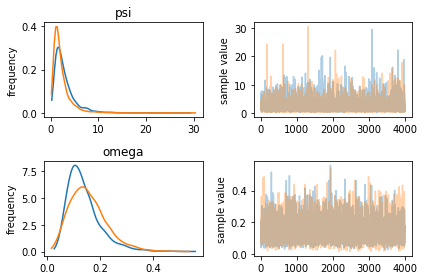

In [157]:
samples.plot(['psi', 'omega']);
plt.tight_layout()

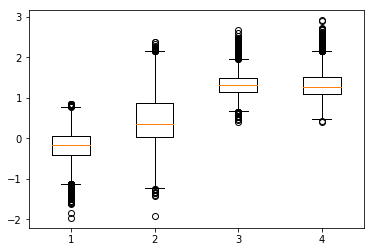

In [158]:
plt.boxplot([[samp['tau'][:, j] for j in range(i*6, (i+1)*6)] for i in range(4)]);

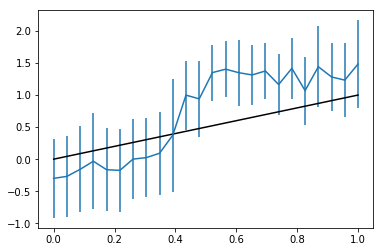

In [159]:
plt.errorbar(time[:24], samp['tau'].mean(0)[:24], yerr = 1.98*samp['tau'].std(0)[:24])
plt.plot([time.min(), time.max()], [time.min(), time.max()], c='k')

In [160]:
samp.keys()

[u'tau',
 u'psi',
 u'omega',
 u'predictedmean',
 u'predictedvar',
 u'logmarglike',
 u'lp__']

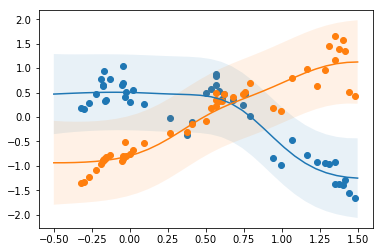

In [161]:
for i in range(exp.shape[0]):
    mu = samp['predictedmean'][:,i,:].mean(0)
    var = samp['predictedvar'][:,i,:].mean(0)
    std = np.sqrt(var)
    
    plt.plot(config['testinput'], mu)
    plt.fill_between(config['testinput'], mu-1.98*std, mu+1.98*std,alpha=.1)

    plt.scatter(samp['tau'].mean(0), exp[i,:]-exp[i,:].mean(), color='C%d'%i)